In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow  as tf

from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle
from typing import List, Dict

In [2]:
vgecocup = tf.keras.models.load_model("../models/vgecocup_version2")
vgecocup.summary()

2022-06-16 23:34:54.418512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
images_pos = os.listdir("../dataset/train/images/pos/")
list_image_pos = []
for image in images_pos:
    list_image_pos.append(f"../dataset/train/images/pos/{image}")
images_neg = os.listdir("../dataset/train/images/neg/")
list_image_neg = []
for image in images_neg:
    list_image_neg.append(f"../dataset/train/images/neg/{image}")
images = list_image_neg + list_image_pos
random.Random(20).shuffle(images)

files = os.listdir("../dataset/train/labels_csv/")
labels = []
for file in files:
    labels.append(file[:-4])
    
df = pd.DataFrame(images, columns=["Image"])
df["label"] = df["Image"].apply(lambda x: 1 if x[25:-4] in labels else 0)
df

,Image,label
0,../dataset/train/images/neg/wangruim_neg_005.jpg,0
1,../dataset/train/images/neg/nivoixpa_neg_007.jpg,0
2,../dataset/train/images/pos/oaitelhi_pos_002.jpg,0
3,../dataset/train/images/pos/amiotnoe_pos_007.jpg,0
4,../dataset/train/images/neg/oaitelhi_neg_001.jpg,0
...,...,...
771,../dataset/train/images/pos/sbenarro_pos_010.jpg,0
772,../dataset/train/images/neg/operezal_neg_002.jpg,0
773,../dataset/train/images/neg/honhuhoa_neg_009.jpg,0
774,../dataset/train/images/pos/smakhlou_pos_002.jpg,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df["Image"], df["label"], random_state=15)

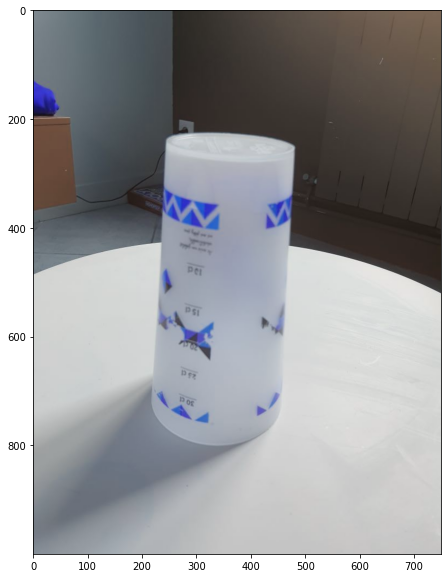

In [8]:
img = cv2.imread(X_test.iloc[1])
plt.figure(figsize=(10, 10))
plt.imshow(img)

In [9]:
def plot_boxes(img, boxes_nms):
    figure, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)
    for box in boxes_nms:
        rect = Rectangle((box["x"],box["y"]),box["w"],box["h"], edgecolor='r', facecolor="none")
        ax.add_patch(rect)
    plt.show()

In [11]:
def get_IoU(box1, box2):
    x1_1 = box1[0]
    y1_1 = box1[1]
    x1_2 = x1_1 + box1[2]
    y1_2 = y1_1 + box1[3]

    x2_1 = box2[0]
    y2_1 = box2[1]
    x2_2 = x2_1 + box2[2]
    y2_2 = y2_1 + box2[3]

    x_1 = max(x1_1, x2_1)
    x_2 = min(x1_2, x2_2)
    y_1 = max(y1_1, y2_1)
    y_2 = min(y1_2, y2_2)

    intersection_area = max(0, x_2 - x_1) * max(0, y_2 - y_1)
    box1_area = (x1_2 - x1_1) * (y1_2 - y1_1)
    box2_area = (x2_2 - x2_1) * (y2_2 - y2_1)
    iou = intersection_area/(box1_area + box2_area - intersection_area)

    return iou

In [10]:
def non_max_suppression(output_model: List[Dict], threshold: float, picture_name: str) -> List:
    boxes_output = []
    boxes = output_model.copy()
    while len(boxes) >= 1:
        boxes_used = sorted(boxes, key=lambda x: x["score"], reverse=True)
        best_prediction = boxes_used[0]
        prediction = {}
        prediction["filename"] = f"{picture_name}.jpg"
        prediction.update(best_prediction)
        boxes_output.append(prediction)
        boxes.remove(best_prediction)
        boxes_used.remove(best_prediction)
        for i in range(len(boxes_used)):
            box = boxes_used[i]
            iou = get_IoU(
                (
                    best_prediction["x"],
                    best_prediction["y"],
                    best_prediction["w"],
                    best_prediction["h"]
                ),
                (
                    box["x"],
                    box["y"],
                    box["w"],
                    box["h"]
                )
            )
            if iou > threshold:
                boxes.remove(box)
    plot_boxes(img=img, boxes_nms=boxes_output)
    return boxes_output
    


In [12]:
def get_image(filepath):
    img = cv2.imread(filepath)
    picture_name = filepath[28:-4]
    return img, picture_name

In [13]:
def get_selective_search_boxes(image, ss):
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()

    return ssresults

In [14]:
def get_vgecocup_output(ssresults, img):
    model_output = []
    imout = img.copy()
    for e, boxes in enumerate(ssresults):
        if e < 3000 or e == len(ssresults):
            x_result, y_result, w_result, h_result = boxes
            if h_result > 0.05*imout.shape[0] and w_result > 0.05*imout.shape[1]:
                test_image = imout[y_result:y_result+h_result, x_result:x_result+h_result]
                resized = cv2.resize(test_image, (224,224), interpolation = cv2.INTER_AREA)
                input_model = np.expand_dims(resized, axis=0)
                vgecocup_result = vgecocup.predict(input_model)
                if vgecocup_result[0][1] > 0.9:
                    model_output.append(
                        {
                            "x": x_result,
                            "y": y_result,
                            "w": w_result,
                            "h": h_result,
                            "score": vgecocup_result[0][1]
                        }
                    )
    
    return model_output

In [15]:
filepathes_validation = list(X_test[0:10])
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
final_output = []
for filepath in filepathes_validation:
    try:
        img, picture_name = get_image(filepath)
        print("Picture: ", picture_name, ".jpg")
        print("Shape: (", img.shape[0], ", ", img.shape[1], ")")
        ssresults = get_selective_search_boxes(img, ss)
        model_output = get_vgecocup_output(ssresults, img)
        model_output_nms = non_max_suppression(model_output, 0.1, picture_name)
        final_output.append(model_output_nms)
    except Exception:
        print()
        print("There is a problem")
        print()


Picture:  smakhlou_pos_006 .jpg
Shape: ( 3024 ,  4032 )
1/1 [==============================] - 0s 365ms/step


KeyboardInterrupt: 